In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [2]:
lr            = joblib.load('nfinal_logreg_model.pkl')
scaler        = joblib.load('standard_scaler.pkl')

# Data en labels inladen
X_ntrain          = pd.read_pickle('X_ontrain.pkl')
y_ntrain          = pd.read_pickle('y_ontrain.pkl')
X_ntrain_scaled   = pd.read_pickle('X_ontrain_scaled.pkl')
X_ntest           = pd.read_pickle('X_ontest.pkl')
y_ntest           = pd.read_pickle('y_ontest.pkl')
X_ntest_scaled    = pd.read_pickle('X_ontest_scaled.pkl')


### Feature Importance

In [3]:
import pandas as pd

feature_names = X_ntrain.columns
coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({
    'Feature':      feature_names,
    'Coefficient':  coefficients
})

# 3. Bereken absolute invloed en het aandeel
feature_importance['AbsCoeff'] = feature_importance['Coefficient'].abs()
total = feature_importance['AbsCoeff'].sum()
feature_importance['Share'] = feature_importance['AbsCoeff'] / total
feature_importance['Share (%)'] = feature_importance['Share'] * 100

# 4. Sorteer en toon
feature_importance = feature_importance.sort_values('Share', ascending=False)
print(feature_importance.reset_index(drop=True))


      Feature  Coefficient  AbsCoeff     Share  Share (%)
0     oldpeak     0.364566  0.364566  0.162237  16.223722
1        cp_4     0.341019  0.341019  0.151758  15.175822
2        cp_2    -0.335908  0.335908  0.149484  14.948408
3       exang     0.283798  0.283798  0.126294  12.629421
4         sex     0.202568  0.202568  0.090145   9.014547
5        chol     0.188443  0.188443  0.083860   8.385971
6         fbs     0.152821  0.152821  0.068007   6.800741
7     thalach    -0.107641  0.107641  0.047902   4.790163
8         age     0.094231  0.094231  0.041934   4.193432
9   restecg_2    -0.056471  0.056471  0.025130   2.513034
10   trestbps     0.050806  0.050806  0.022609   2.260938
11  restecg_0     0.028787  0.028787  0.012811   1.281077
12       cp_3    -0.027690  0.027690  0.012323   1.232258
13  restecg_1    -0.008785  0.008785  0.003910   0.390967
14       cp_1     0.003584  0.003584  0.001595   0.159500


### SHAP

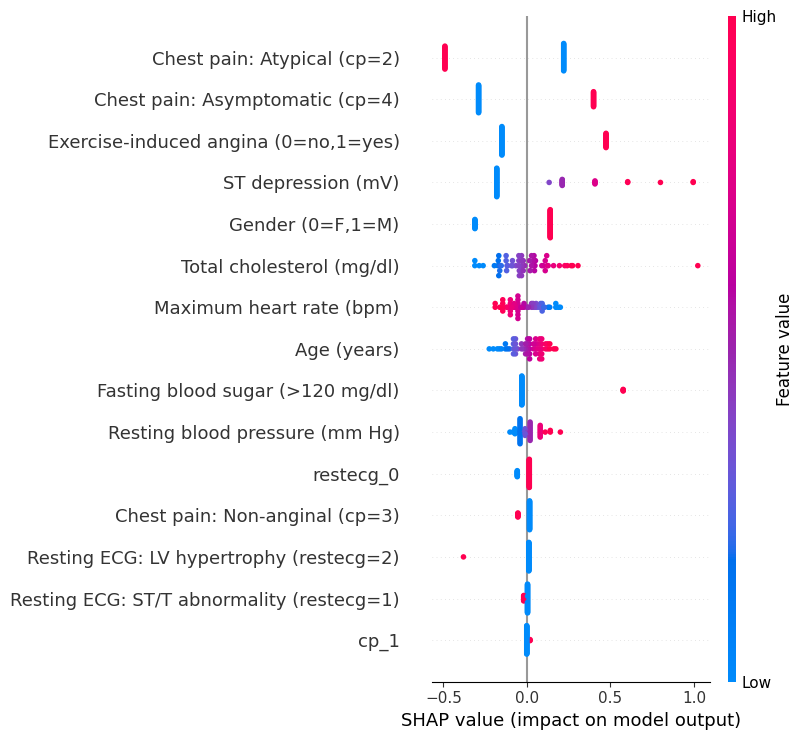

In [7]:
# Definieer een mapping van oude naar nieuwe namen
new_names = {
    'age':         'Leeftijd (jr)',
    'sex':         'Geslacht (0=V,1=M)',
    'trestbps':    'Bloeddruk (mmHg)',
    'chol':        'Cholesterol (mg/dl)',
    'fbs':         'Nuchtere suiker',
    'thalach':     'Max. hartslag (bpm)',
    'exang':       'Hartkramp bij inspanning',
    'oldpeak':     'ST-depressie (mV)',
    # cp-dummies:
    'cp_2':        'Borstpijn: Atypisch (cp=2)',
    'cp_3':        'Borstpijn: Niet-cardiaal (cp=3)',
    'cp_4':        'Borstpijn: Asymptomatisch (cp=4)',
    # restecg-dummies:
    'restecg_1':   'Rust-ECG: ST-/T-afwijking (restecg=1)',
    'restecg_2':   'Rust-ECG: LV-hypertrofie (restecg=2)'
}

# 2. Pas de namen toe op je geschaalde DataFrames
X_ntrain_scaled.rename(columns=new_names, inplace=True)
X_ntest_scaled.rename(columns=new_names, inplace=True)

# 3. Maak de SHAP-explainer en -waarden opnieuw aan met de nieuwe kolomnamen
import shap
explainer = shap.Explainer(lr, X_ntrain_scaled)
shap_values = explainer(X_ntest_scaled)

# 4. Plot met alle hernoemde features
shap.summary_plot(
    shap_values,
    X_ntest_scaled,
    feature_names=X_ntest_scaled.columns,
    max_display=X_ntest_scaled.shape[1]
)


> engels voor rapport

c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


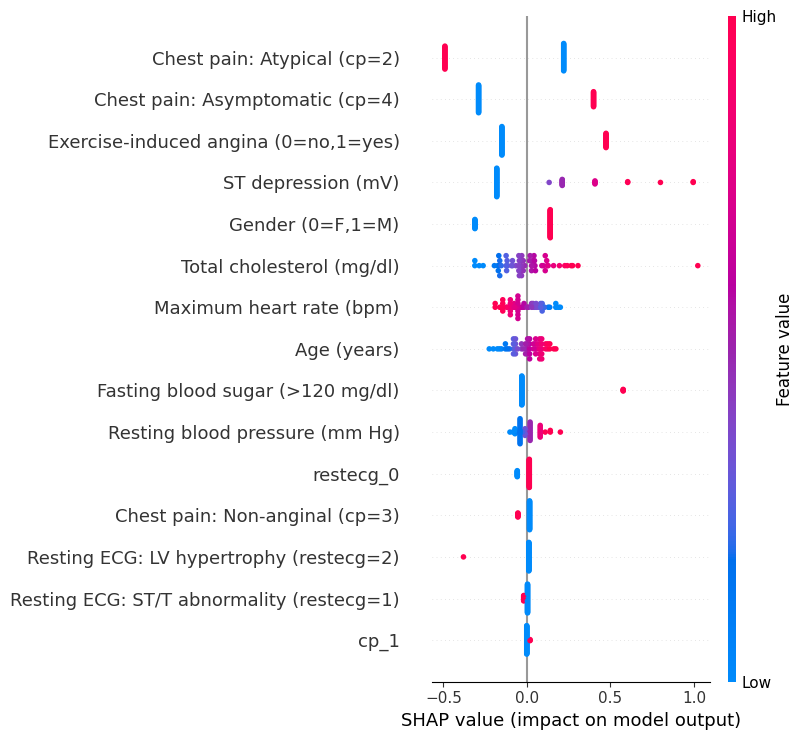

In [4]:
import shap

explainer = shap.Explainer(lr, X_ntrain_scaled)

shap_values = explainer(X_ntest_scaled)

new_names_en = {
    'age':         'Age (years)',
    'sex':         'Gender (0=F,1=M)',
    'trestbps':    'Resting blood pressure (mm Hg)',
    'chol':        'Total cholesterol (mg/dl)',
    'fbs':         'Fasting blood sugar (>120 mg/dl)',
    'thalach':     'Maximum heart rate (bpm)',
    'exang':       'Exercise-induced angina (0=no,1=yes)',
    'oldpeak':     'ST depression (mV)',
    # Chest pain dummies (cp)
    'cp_2':        'Chest pain: Atypical (cp=2)',
    'cp_3':        'Chest pain: Non-anginal (cp=3)',
    'cp_4':        'Chest pain: Asymptomatic (cp=4)',
    # Resting ECG dummies (restecg)
    'restecg_1':   'Resting ECG: ST/T abnormality (restecg=1)',
    'restecg_2':   'Resting ECG: LV hypertrophy (restecg=2)'
}

X_ntrain_scaled.rename(columns=new_names_en, inplace=True)
X_ntest_scaled.rename(columns=new_names_en, inplace=True)


import shap
explainer = shap.Explainer(lr, X_ntrain_scaled)
shap_values = explainer(X_ntest_scaled)


shap.summary_plot(
    shap_values,
    X_ntest_scaled,
    feature_names=X_ntest_scaled.columns,
    max_display=X_ntest_scaled.shape[1]
)


In [6]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

share = mean_abs_shap / mean_abs_shap.sum()

importance_df = pd.DataFrame({
    'Feature':  X_ntest_scaled.columns.to_list(),          # lijst zoals in je plot
    'Mean |SHAP|': mean_abs_shap,
    'Share (%)': share * 100
})

# 4) Sorteer en print
importance_df = importance_df.sort_values('Share (%)', ascending=False).reset_index(drop=True)
print(importance_df)


                                      Feature  Mean |SHAP|  Share (%)
0                 Chest pain: Atypical (cp=2)     0.344086  18.567843
1             Chest pain: Asymptomatic (cp=4)     0.328165  17.708698
2        Exercise-induced angina (0=no,1=yes)     0.259403  13.998112
3                          ST depression (mV)     0.256011  13.815056
4                            Gender (0=F,1=M)     0.183274   9.889972
5                   Total cholesterol (mg/dl)     0.130926   7.065129
6                    Maximum heart rate (bpm)     0.088401   4.770360
7                                 Age (years)     0.077813   4.199015
8            Fasting blood sugar (>120 mg/dl)     0.067353   3.634559
9              Resting blood pressure (mm Hg)     0.047938   2.586858
10                                  restecg_0     0.022444   1.211159
11             Chest pain: Non-anginal (cp=3)     0.021161   1.141928
12    Resting ECG: LV hypertrophy (restecg=2)     0.017975   0.969962
13  Resting ECG: ST/